In [1]:
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 65.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, Flatten, Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import itertools

In [3]:
#columns = ['target', 'id', 'date', 'flag', 'user', 'text']
movie_data = pd.read_csv("/content/IMDB Dataset.csv")

In [4]:
movie_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Download stopwords for further processing
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# Lowercasing
movie_data['review'] = movie_data['review'].apply(lambda x: x.lower())

In [7]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and numbers
    text = re.sub(r'\@\w+|\#|\d+', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    return text

movie_data['review'] = movie_data['review'].apply(clean_text)

In [8]:
movie_data['review'] = movie_data['review'].apply(word_tokenize)


In [9]:
movie_data['sentiment'].replace("positive", 1, inplace=True)
movie_data['sentiment'].replace("negative", 0, inplace=True)

In [10]:
value_counts = movie_data['sentiment'].value_counts()
print(value_counts)

sentiment
1    25000
0    25000
Name: count, dtype: int64


In [11]:
stop_words = set(stopwords.words('english'))

movie_data['review'] = movie_data['review'].apply(lambda x: [word for word in x if word not in stop_words])


In [12]:
# Define the tokenizer with a vocabulary size (e.g., 10000)
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(movie_data['review'])
word_index = tokenizer.word_index
# Convert the text to sequences of integers
sequences = tokenizer.texts_to_sequences(movie_data['review'])

# Pad the sequences so they all have the same length
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

In [13]:
# Load the GloVe embeddings
embedding_index = {}
with open("/content/glove.6B.50d.txt", "r", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create an embedding matrix
embedding_dim = 50
embedding_matrix = np.zeros((10000, embedding_dim))
for word, i in word_index.items():
    if i < 10000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [14]:
# Convert labels to numpy array
labels = np.array(movie_data['sentiment'])

# Split the data into training and validation sets
train_padded, val_padded, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2)
val_padded, test_padded, val_labels, test_labels = train_test_split(val_padded, val_labels, test_size=0.2)

# **################################################**

# **PLAIN NN**

In [37]:
def create_nn(neurons=64, learning_rate=0.001, dropout_rate=0.5):
    model_nn = tf.keras.Sequential()
    model_nn.add(Embedding(input_dim=10000, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False))
    model_nn.add(Flatten())
    model_nn.add(Dense(neurons, activation='relu'))
    model_nn.add(Dropout(dropout_rate))
    model_nn.add(Dense(neurons, activation='relu'))
    model_nn.add(Dropout(dropout_rate))
    model_nn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model_nn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model_nn


In [38]:
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 20, 30],
    'neurons': [16, 32, 64, 128],  # Tuning the number of neurons in the LSTM layer
    'learning_rate': [0.01, 0.001, 0.0001],  # Tuning the learning rate
    'dropout_rate': [0.0, 0.3, 0.6, 0.9]  # Tuning the dropout rate
}

In [42]:
def grid_search(X_train, y_train, X_val, y_val, param_grid, create_nn):
    # Generate all combinations of hyperparameters
    param_combinations = list(itertools.product(
        param_grid['neurons'],
        param_grid['learning_rate'],
        param_grid['dropout_rate'],
        param_grid['batch_size'],
        param_grid['epochs']
    ))

    best_score = 0
    best_params = None
    best_model = None
    best_history = None

    # Iterate over all combinations
    for neurons, learning_rate, dropout_rate, batch_size, epochs in param_combinations:
        # Create and train the model
        model = create_nn(neurons=neurons, learning_rate=learning_rate, dropout_rate=dropout_rate)

        # Set up EarlyStopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        # Fit the model
        history = model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping]
        )

        # Evaluate the model on the validation set
        val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

        print(f"Parameters: neurons={neurons}, learning_rate={learning_rate}, dropout_rate={dropout_rate}, batch_size={batch_size}, epochs={epochs}")
        print(f"Validation Accuracy: {val_accuracy}")

        # Save the best model based on validation accuracy
        if val_accuracy > best_score:
            best_score = val_accuracy
            best_params = {
                'neurons': neurons,
                'learning_rate': learning_rate,
                'dropout_rate': dropout_rate,
                'batch_size': batch_size,
                'epochs': epochs
            }
            best_model = model
            best_history = history

    print("Best parameters found: ", best_params)
    print("Best validation accuracy: ", best_score)

    return best_model, best_history

In [43]:
def plot_history(history, save_path):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

In [ ]:
best_model, best_history = grid_search(train_padded, train_labels, val_padded, val_labels, param_grid, create_nn)

# Save plots for the best model
plot_history(best_history, 'best_model_training_history.png')

# Optionally evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy of the best model: ", test_accuracy)

Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.0, batch_size=32, epochs=10
Validation Accuracy: 0.7236250042915344
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.0, batch_size=32, epochs=20
Validation Accuracy: 0.7208750247955322
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.0, batch_size=32, epochs=30
Validation Accuracy: 0.7211250066757202
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.0, batch_size=64, epochs=10
Validation Accuracy: 0.7227500081062317
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.0, batch_size=64, epochs=20
Validation Accuracy: 0.7282500267028809
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.0, batch_size=64, epochs=30
Validation Accuracy: 0.7213749885559082
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.3, batch_size=32, epochs=10
Validation Accuracy: 0.5062500238418579
Parameters: neurons=16, learning_rate=0.01, dropout_rate=0.3, batch_size=32, epochs=20
Validation Accuracy: 0.7

In [33]:
history_nn = model_nn.fit(
    train_padded,  # Training data
    train_labels,  # Training labels
    epochs=10,  # Number of epochs (adjust based on your dataset)
    validation_data=(val_padded, val_labels),  # Validation data and labels
    batch_size=64,  # Adjust the batch size according to your data size
    verbose=1  # Set verbose to 1 for detailed progress during training
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5746 - loss: 0.6687 - val_accuracy: 0.7154 - val_loss: 0.5734
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6690 - loss: 0.5994 - val_accuracy: 0.7211 - val_loss: 0.5581
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6906 - loss: 0.5778 - val_accuracy: 0.7235 - val_loss: 0.5553
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6925 - loss: 0.5662 - val_accuracy: 0.7291 - val_loss: 0.5437
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6996 - loss: 0.5580 - val_accuracy: 0.7199 - val_loss: 0.5516
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7050 - loss: 0.5517 - val_accuracy: 0.7182 - val_loss: 0.5540
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7074 - loss: 0.5438 - val_accuracy: 0.7209 - val_loss: 0.5467
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7099 - loss: 0.5332 - val_accuracy: 0.

In [34]:
# Evaluate the model on test data
test_loss, test_acc = model_nn.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7305 - loss: 0.5491
Test Accuracy: 0.718999981880188


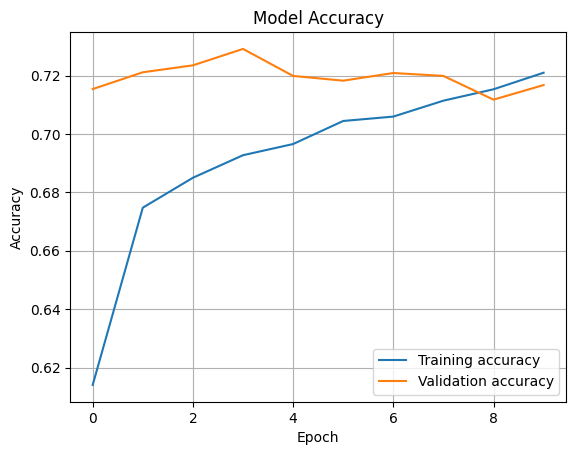

In [35]:
plt.plot(history_nn.history['accuracy'], label = "Training accuracy")
plt.plot(history_nn.history['val_accuracy'], label = "Validation accuracy")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

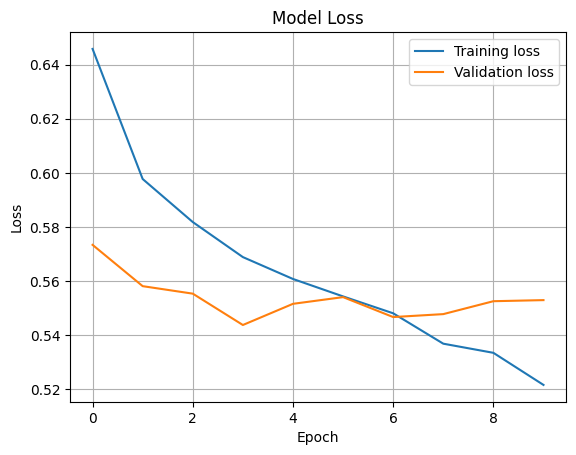

In [36]:
plt.plot(history_nn.history['loss'], label = "Training loss")
plt.plot(history_nn.history['val_loss'], label = "Validation loss")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

# **##########################################**

# **LSTM**

In [ ]:

# Assuming your input data is tokenized and padded (train_padded, val_padded, etc.)
model_lstm = tf.keras.Sequential()

# Embedding layer (optional if using pre-trained embeddings)
model_lstm.add(Embedding(input_dim=10000, output_dim=50, weights=[embedding_matrix], trainable=False))

# LSTM layer
model_lstm.add(LSTM(64, kernel_regularizer=regularizers.l2(0.001)))  # 64 units for LSTM, you can adjust this value

# Dropout for regularization
model_lstm.add(Dropout(0.9))

# Output layer for binary classification
model_lstm.add(Dense(1, activation='sigmoid'))
learning_rate = 0.001  # Adjust this value as needed
optimizer = Adam(learning_rate=0.001)

# Compile the model
model_lstm.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history_lstm = model_lstm.fit(
    train_padded,  # Training data
    train_labels,  # Training labels
    epochs=50,  # Adjust the number of epochs based on your data
    validation_data=(val_padded, val_labels),  # Validation data
    batch_size=64,  # Batch size
    verbose=1
)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5021 - loss: 0.7600 - val_accuracy: 0.5131 - val_loss: 0.7043
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5059 - loss: 0.7042 - val_accuracy: 0.5269 - val_loss: 0.6971
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5117 - loss: 0.6976 - val_accuracy: 0.5379 - val_loss: 0.6921
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5480 - loss: 0.6919 - val_accuracy: 0.5870 - val_loss: 0.6790
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5658 - loss: 0.6873 - val_accuracy: 0.5932 - val_loss: 0.6743
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5811 - loss: 0.6842 - val_accuracy: 0.6022 - val_loss: 0.6747
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5914 - loss: 0.6787 - val_accuracy: 0.5996 - val_loss: 0.6728
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6014 - loss: 0.6756 - val_accuracy: 0.

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model_lstm.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7111 - loss: 0.5720
Test Accuracy: 0.7285000085830688


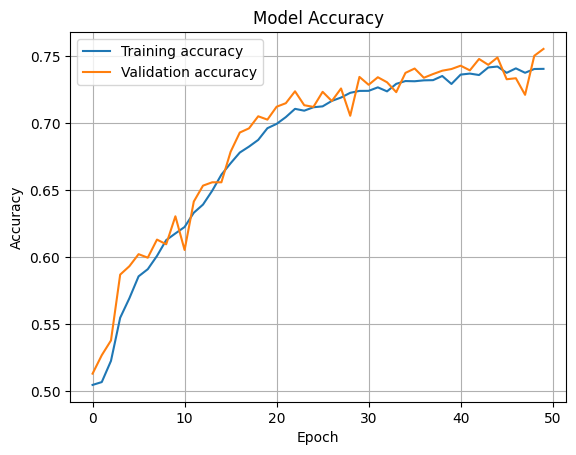

In [ ]:
plt.plot(history_lstm.history['accuracy'], label = "Training accuracy")
plt.plot(history_lstm.history['val_accuracy'], label = "Validation accuracy")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

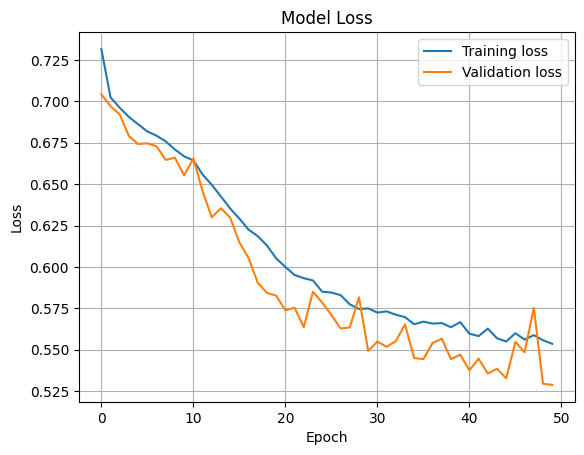

In [ ]:
plt.plot(history_lstm.history['loss'], label = "Training loss")
plt.plot(history_lstm.history['val_loss'], label = "Validation loss")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

# **###########################**

# **LSTM BIDIRECTIONAL**

In [ ]:
# Assuming your input data is tokenized and padded (train_padded, val_padded, etc.)
model_lstm_bi = tf.keras.Sequential()

# Embedding layer (optional if using pre-trained embeddings)
model_lstm_bi.add(Embedding(input_dim=10000, output_dim=50, weights=[embedding_matrix], trainable=False))

# LSTM layer
model_lstm_bi.add(Bidirectional(LSTM(64, kernel_regularizer=regularizers.l2(0.001))))  # 64 units for LSTM, you can adjust this value

# Dropout for regularization
model_lstm_bi.add(Dropout(0.9))

# Output layer for binary classification
model_lstm_bi.add(Dense(1, activation='sigmoid'))
learning_rate = 0.001  # Adjust this value as needed
optimizer = Adam(learning_rate=0.001)

# Compile the model
model_lstm_bi.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history_lstm_bi = model_lstm_bi.fit(
    train_padded,  # Training data
    train_labels,  # Training labels
    epochs=100,  # Adjust the number of epochs based on your data
    validation_data=(val_padded, val_labels),  # Validation data
    batch_size=64,  # Batch size
    verbose=1
)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7512 - loss: 0.5447 - val_accuracy: 0.7483 - val_loss: 0.5379
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7485 - loss: 0.5438 - val_accuracy: 0.7400 - val_loss: 0.5442
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7433 - loss: 0.5478 - val_accuracy: 0.7538 - val_loss: 0.5310
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7526 - loss: 0.5394 - val_accuracy: 0.7535 - val_loss: 0.5253
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7490 - loss: 0.5471 - val_accuracy: 0.7545 - val_loss: 0.5248
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7541 - loss: 0.5401 - val_accuracy: 0.7418 - val_loss: 0.5473
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7453 - loss: 0.5487 - val_accuracy: 0.7465 - val_loss: 0.5360
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7481 - loss: 0.5442

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model_lstm.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7111 - loss: 0.5720
Test Accuracy: 0.7285000085830688


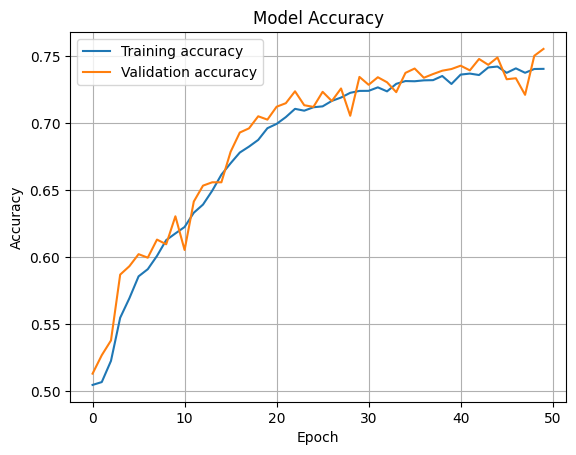

In [ ]:
plt.plot(history_lstm.history['accuracy'], label = "Training accuracy")
plt.plot(history_lstm.history['val_accuracy'], label = "Validation accuracy")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

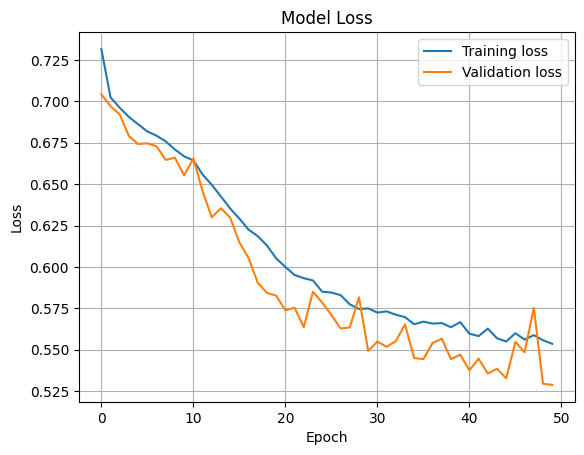

In [ ]:
plt.plot(history_lstm.history['loss'], label = "Training loss")
plt.plot(history_lstm.history['val_loss'], label = "Validation loss")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()